# We learn how to work with wavefunctions, depict states on Bloch spheres and also use Gate Identities to simplify circuits

We assume QuTip, Cython, Numpy have been installed and PyQuil configured with the Forest API Key

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

## Bloch Sphere 

In [1]:
from qutip import Bloch

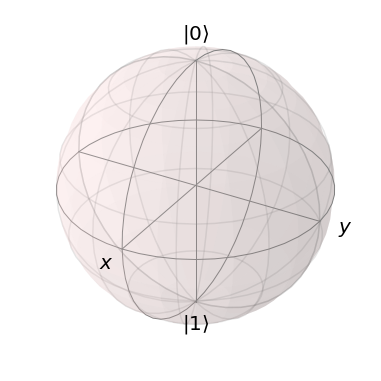

In [2]:
#initialise empty Bloch
bloch_sphere=Bloch()
bloch_sphere.show()

The general state $\ket{\psi}$ is expressed as $\ket{\psi} = \alpha\ket{0} + \beta\ket{1}$. <br> For the purpose of representing states on the Bloch Sphere, we express them in the following form: <br>
$$\ket{\psi} = \cos(\frac{\theta}{2}) \ket{0} + e^{i\phi}\sin(\frac{\theta}{2}) \ket{1}$$
where
$$0 \leq \theta \leq \pi$$ and $$0 \leq \phi < 2\pi$$.

We can then obtain the Cartesian Coordinates $x, y, z$ as follows: <br>

$$x = \sin(\theta)\cos(\phi)$$
$$y = \sin(\theta)\sin(\phi)$$
$$z = \cos(\theta)$$

The functions below are defined to remove the Global phase from a given $(\alpha,\beta)$ description of $\ket{\psi}$ and to plot the amplitude vector on the Bloch Sphere

In [3]:
import cmath
import numpy as np

def get_vector(alpha, beta):
    """
    Function to compute 3D Cartesian coordinates
    from 2D qubit vector.
    """

    # get phases
    angle_alpha = cmath.phase(alpha)
    angle_beta = cmath.phase(beta)
    
    # avoiding wrong normalization due to rounding errors
    if cmath.isclose(angle_alpha, cmath.pi):
        angle_alpha = 0
    if cmath.isclose(angle_beta, cmath.pi):
        angle_beta = 0

    if (angle_beta < 0 and angle_alpha < angle_beta) or (angle_beta > 0 and angle_alpha > angle_beta):
            denominator = cmath.exp(1j*angle_beta)
    else:
            denominator = cmath.exp(1j*angle_alpha)

    # eliminate global phase
    alpha_new = alpha/denominator
    beta_new = beta/denominator

    # special case to avoid division by zero
    if abs(alpha) == 0 or abs(beta) == 0:
        if alpha == 0:
            return [0,0,-1]
        else:
            return [0,0,1]
    else:
        # compute theta and phi from alpha and beta
        theta = 2*cmath.acos(alpha_new)
        phi = -1j*cmath.log(beta_new/cmath.sin(theta/2))

        # compute the Cartesian coordinates
        x = cmath.sin(theta)*cmath.cos(phi)
        y = cmath.sin(theta)*cmath.sin(phi)
        z = cmath.cos(theta)

    return [x.real,y.real,z.real]

def plot_quantum_state(sphere, amplitudes):
    """
    Thin function to abstract the plotting on the Bloch sphere.
    """
    bloch_sphere = Bloch()
    vec = get_vector(amplitudes[0], amplitudes[1])
    bloch_sphere.add_vectors(vec)
    bloch_sphere.show()
    bloch_sphere.clear()

## Wavefunctions

All qubits get initialised to zero

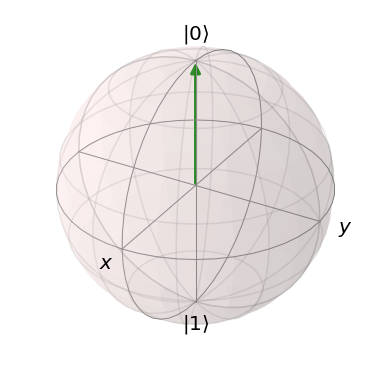

In [4]:
from pyquil.api import QVMConnection
from pyquil.quil import Program
from pyquil.gates import *

# initialize a QVMConnection with Rigetti's server
qvm = QVMConnection()

# initialize a pyQuil program that measures the initial qubit state
p = Program()
#p.inst(X(0),H(0))
p.measure(0, 0)

# TODO: find out how to get the resulting wavefunction + amplitudes after running the program in the QVM
wavefunction = qvm.wavefunction(p)
amplitudes = wavefunction.amplitudes

# now we can call our custom function to plot the quantum state
plot_quantum_state(bloch_sphere, amplitudes)

Plotting the probabilities:


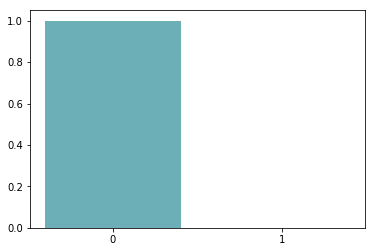

Pretty printing the wavefunction: 

(1+0j)|0> 

Pretty printing the probabilities: 

{'0': 1.0}


In [5]:
print('Plotting the probabilities:')
wavefunction.plot()

print('Pretty printing the wavefunction: \n')
print(f'{wavefunction.pretty_print()} \n')

print('Pretty printing the probabilities: \n')
print(wavefunction.pretty_print_probabilities())

## Gates

Applying Gates in loops

Probabilities after applying H 2 times:


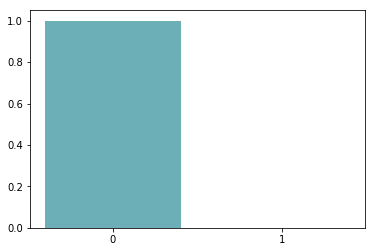

Probabilities after applying H 3 times:


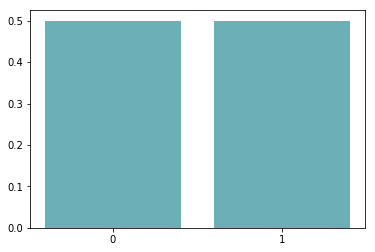

Probabilities after applying H 4 times:


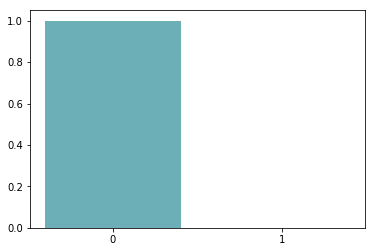

In [6]:
for i in range(2, 5):
    # TODO: apply the Hadamard gate multiple times
    p = Program(H(0) for k in range(i))
    
    # TODO: get the wavefunction from the QVM 
    # and plot the probability distribution
    wavefunction = qvm.wavefunction(p)
    print(f'Probabilities after applying H {i} times:')
    wavefunction.plot()

### Action of Pauli Gates

In [7]:
# TODO: import the Pauli gates (Identity, X, Y, Z).
from pyquil.gates import I, X, Y, Z

def apply_pauli_gates(state_tuple):
    """
    Given a program that initializes an initial state this function
    will apply each Pauli gate once and plot the resulting state
    on the Bloch sphere.
    """
    initial_state = state_tuple[0] 
    state_name = state_tuple[1]
    for pauli_gate in [I(0), X(0), Y(0), Z(0)]:
        p = Program()
        p.inst(pauli_gate)
        p = initial_state + p
        amplitudes = qvm.wavefunction(p).amplitudes
        print(f"{pauli_gate.name}'s action on the {state_name} state:")
        plot_quantum_state(bloch_sphere, amplitudes)

# TODO: try I, X, Y, Z on different initial quantum states!

from pyquil.gates import H, S # needed to get initial state to x or y axis


def interact_pauli_gates(x):
    list_of_states=[(Program(),'|+z>'), (Program(X(0)), '|-z>'), (Program(H(0)), '|+x>'), (Program(X(0), H(0)), '|-x>'), (Program(H(0), S(0)), '|+y>'), (Program(X(0), H(0), S(0)), '|-y>')]
    state=list_of_states[x]
    apply_pauli_gates(state)

In [8]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

print('Move slider to choose different initial states')

interact(interact_pauli_gates, x=(0,5));

Move slider to choose different initial states


interactive(children=(IntSlider(value=2, description='x', max=5), Output()), _dom_classes=('widget-interact',)…

### Different ways of applying Gates

In [9]:

# try putting multiple gates into a single .inst() call
p = Program()
p.inst(H(0), H(1), H(2))
print(f'Many gates in one .inst() call:\n{p} \n')

# chain multiple .inst() call after each other and add a final MEASURE or .measure statement
p = Program()
p.inst(H(0)).inst(H(1)).inst(H(2)).measure(0,0)
print(f'Chained .inst() calls:\n{p} \n')

# try to mix the two possibilities above
p = Program()
p.inst(H(0)).inst(H(1), H(2)).measure(0,0)
print(f'Mixing the two:\n{p} \n')

# use a Python generator to populate a Program
p = Program()
p.inst(H(i) for i in range(3))
print(f'With generator:\n{p} \n')

# define three programs and then ADD them together and print it. What do you observe?
p0 = Program().inst(H(0))
p1 = Program().inst(H(1))
p2 = Program().inst(H(2))
p = p0 + p1 + p2
print(f'With addition:\n{p} \n')

Many gates in one .inst() call:
H 0
H 1
H 2
 

Chained .inst() calls:
H 0
H 1
H 2
MEASURE 0 [0]
 

Mixing the two:
H 0
H 1
H 2
MEASURE 0 [0]
 

With generator:
H 0
H 1
H 2
 

With addition:
H 0
H 1
H 2
 



Using pop to remove the last instruction to Quil

In [10]:
# TODO: Use .pop() on the last program from Ex. 4.4
print(f'Before .pop():\n{p}')
p.pop()
print(f'After .pop():\n{p}')

# Observation: it pops/deletes the last quantum gate in the Program

Before .pop():
H 0
H 1
H 2

After .pop():
H 0
H 1



### Ordering of Qubits

In [11]:
from pyquil.gates import X, I

p = Program()

# TODO: implement an X gate on qubit 0 and an identity gate on qubit 1
p.inst(X(0), I(1))

# TODO: print the wavefunction
print(qvm.wavefunction(p))

# Observation: the qubits are ordered in reverse |q_N,..., q_1, q_0>

(1+0j)|01>


## Defining Gates

Define the following gate manually:
$U =  \begin{bmatrix}
e^{i\frac{2}{3}\pi} & 0 \\
0 & e^{-i\frac{2}{3}\pi}
\end{bmatrix}$

(-0.5+0.8660254038j)|0>


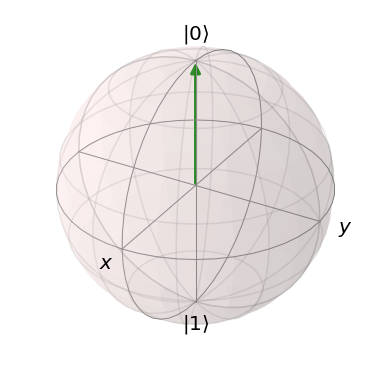

In [12]:
# TODO: Implement custom single-qubit rotation with pyQuil

# implementing u
u = np.array([[cmath.exp(1j*(2/3)*cmath.pi), 0], [ 0, cmath.exp(-1j*(2/3)*cmath.pi)]])

# define the new gate
p = Program().defgate("U", u)

# now we can use it in a Program
p.inst(("U", 0))
#p.inst(H(0))

print(qvm.wavefunction(p))
plot_quantum_state(bloch_sphere, qvm.wavefunction(p).amplitudes)

### T & S Gates


- S gate rotates 90 degrees around the Z axis
- T gate rotates 45 degrees around the Z axis
<br><br>
- The Hadamard gate rotates 180 degrees around the Z+X axis
- You can also visualize it as a 90 degree rotation around Y followed by a 180 degree rotation around X 

Initial state (|+>):


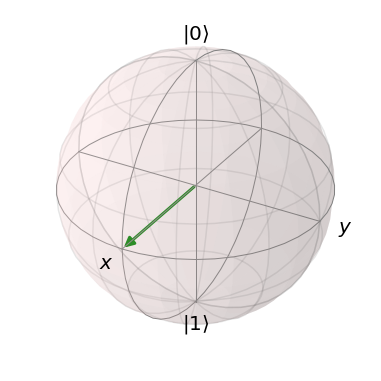

S gate's action on the |+> state:


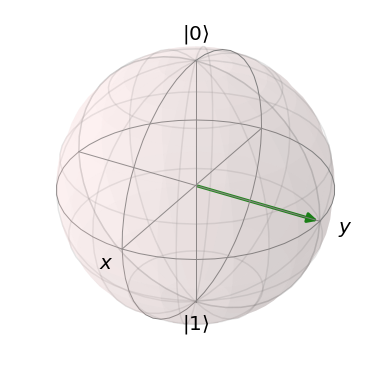

T gate's action on the |+> state:


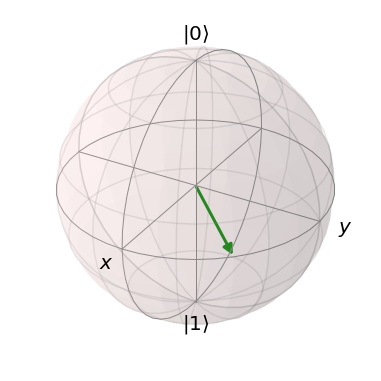

In [13]:
# TODO: import the T and S gate
from pyquil.gates import T, S

initial_state = Program().inst(H(0))
amplitudes = qvm.wavefunction(initial_state).amplitudes

print("Initial state (|+>):")
plot_quantum_state(bloch_sphere, amplitudes)

# TODO: try T and S on different initial quantum states!

# testing the S gate
p = Program()
p.inst(S(0))
p = initial_state + p
amplitudes = qvm.wavefunction(p).amplitudes

print("S gate's action on the |+> state:")
plot_quantum_state(bloch_sphere, amplitudes)

# testing the T gate
p = Program()
p.inst(T(0))
p = initial_state + p
amplitudes = qvm.wavefunction(p).amplitudes

print("T gate's action on the |+> state:")
plot_quantum_state(bloch_sphere, amplitudes)

### Parameterised Gates

Defining a parameterised Gate $U$ with parameter $\phi$ and matrix as below:

$$U =  \begin{bmatrix}
1 & 0 \\
0 & e^{i\phi}
\end{bmatrix}$$

In [14]:
from pyquil.parameters import Parameter, quil_exp
from pyquil.quilbase import DefGate
from pyquil.gates import X
# TODO: Manually create a parametric controlled U gate

phi = Parameter('phi')
u = np.array([[1, 0], [0, quil_exp(1j*phi)]])

dg = DefGate('U', u, [phi])
U = dg.get_constructor()

p = Program()
p.inst(dg) # register the new gate

p.inst(X(0))
p.inst(U(cmath.pi/4)(0)) # use the new gate

print(qvm.wavefunction(p))

(0.7071067812+0.7071067812j)|1>


## Circuit Optimisation

Refer to **Quantum Circuit Identities** by *Chris Lemont* (2003) [here](https://arxiv.org/pdf/quant-ph/0307111.pdf) for a list of Gate Identities.
<br> Consider writing a script that reads the identities and then uses them as a lookup to simplify any given circuit in the form of, say, a JSON.